In [35]:
import argparse
import os

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as trn
from tqdm import tqdm

from torchcp.classification.predictors import ClusterPredictor, ClassWisePredictor, SplitPredictor
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchcp.classification import Metrics
from torchcp.utils import fix_randomness
from common.dataset import build_dataset

In [36]:
args=argparse.Namespace

args.model_name='vgg11'
args.seed=0
args.alpha=0.1

fix_randomness(seed=args.seed)

In [37]:
model=models.__dict__[args.model_name](progress=True, pretrained=True)
model_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(model_device)
model.eval()

dataset = build_dataset('imagenet')

/data/home/huqiang/.conda/envs/huq/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/home/huqiang/.conda/envs/huq/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
cal_dataset, test_dataset = torch.utils.data.random_split(dataset, [25000, 25000])
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

alpha=args.alpha

score_function=SAPS(weight=0.5)
predictor=ClusterPredictor(score_function,model)

# print(f"Experiment--Data : ImageNet, Model : {args.model_name}, Score : {args.score}, Predictor : {args.predictor}, Alpha : {alpha}")
print(f"The size of calibration set is {len(cal_dataset)}.")
predictor.calibrate(cal_data_loader, alpha)
resuls=predictor.evaluate(test_data_loader)

The size of calibration set is 25000.


/data/home/huqiang/.conda/envs/huq/lib/python3.11/site-packages/torchcp/classification/predictors/split.py:67: UserWarning: The value of quantile exceeds 1. It should be a value in (0,1). To avoid program crash, the threshold is set as torch.inf.
  warnings.warn(


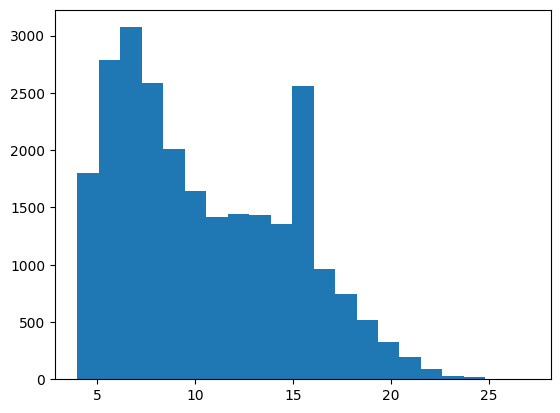

[10, 12, 6, 8, 8, 5, 12, 15, 14, 10, 5, 10, 9, 9, 7, 14, 15, 8, 14, 8, 7, 8, 19, 7, 16, 15, 8, 8, 7, 7, 8, 20, 8, 12, 13, 8, 8, 9, 15, 16, 11, 7, 9, 7, 17, 8, 16, 17, 23, 7, 5, 9, 6, 5, 9, 22, 5, 14, 6, 13, 8, 8, 8, 10, 22, 12, 7, 14, 7, 16, 9, 8, 7, 7, 6, 19, 5, 8, 15, 8, 9, 12, 9, 8, 9, 12, 14, 6, 17, 5, 20, 16, 6, 8, 13, 10, 24, 14, 17, 11, 12, 16, 16, 8, 14, 10, 10, 15, 5, 10, 10, 9, 10, 9, 9, 12, 5, 9, 10, 14, 18, 5, 16, 7, 9, 12, 7, 14, 7, 11, 12, 17, 6, 7, 16, 15, 12, 7, 6, 15, 6, 6, 16, 6, 7, 6, 9, 5, 10, 9, 15, 13, 7, 8, 20, 5, 15, 21, 10, 16, 8, 11, 8, 16, 18, 14, 16, 9, 16, 19, 12, 5, 17, 6, 6, 16, 7, 10, 15, 12, 10, 16, 9, 20, 13, 6, 11, 9, 17, 8, 14, 16, 9, 14, 9, 21, 14, 8, 16, 16, 11, 9, 8, 9, 6, 8, 5, 5, 9, 8, 19, 8, 8, 13, 9, 6, 10, 6, 8, 9, 10, 8, 7, 11, 8, 8, 21, 5, 8, 9, 10, 16, 16, 8, 6, 9, 16, 17, 7, 5, 9, 17, 6, 7, 7, 10, 15, 14, 12, 11, 10, 12, 7, 20, 9, 9, 6, 17, 8, 7, 5, 14, 7, 6, 13, 6, 9, 9, 7, 6, 5, 7, 13, 14, 16, 19, 15, 10, 11, 10, 7, 21, 15, 8, 9, 6, 15,

In [39]:
import matplotlib.pyplot as plt
set_sizes=[len(i) for i in resuls["Prediction_set"]]

# x = [value1, value2, value3,....]
plt.hist(set_sizes, bins=21)
plt.show()
print(set_sizes)